# Train a NN to predict wpm performance


## Set up


In [1]:
# Set up to use local modules
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
sys.path.insert(0, module_path)

In [2]:
import time

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR

from src import process
from src import plot
from src import models

# Load the CSV file results.csv into a dataframe and add some processed columns
df = process.load_processed_results()

display(df.tail())

,id,is_pb,wpm,acc,raw_wpm,consistency,char_stats,mode,mode2,quote_length,...,iti_all,iti_session,time_since_last_new_sesh,combined_id,trial_type_id,z_wpm,z_acc,trial_num,trial_type_num,log_norm_wpm
1823,65940c8ea65b7d25a1993863,0,33.2,96.80,33.2,60.01,"332,0,0,0",time,120,-1,...,18.0,18.0,138000,29,2,1.445331,1.029419,1824,358,7.839566
1824,65940d16a65b7d25a1993e31,0,31.0,91.20,31.0,61.47,"310,0,0,0",time,120,-1,...,16.0,16.0,274000,29,2,0.914677,-0.514066,1825,359,6.796597
1825,65955ea2a65b7d25a1a4b674,0,33.5,95.99,33.5,63.41,"335,0,0,0",time,120,-1,...,86292.0,NaN,0,29,2,1.517693,0.806165,1826,360,7.981789
1826,65955f2ea65b7d25a1a4bc77,0,33.4,95.20,33.4,62.92,"334,0,0,0",time,120,-1,...,20.0,20.0,140000,29,2,1.493572,0.588423,1827,361,7.934381
1827,65955faba65b7d25a1a4c20f,0,29.7,90.91,29.7,58.77,"297,0,0,0",time,120,-1,...,5.0,5.0,0,29,2,0.601110,-0.593997,1828,362,6.180298


## Train a network

Adapted methods from <https://appsilon.com/pytorch-neural-network-tutorial/>

Features: combined_id, acc, index of all trials, index of trial-type trials
Target: wpm


In [3]:
# Prepare data

# Include trial types above a certain threshold of occurances
min_trials = 100
trial_type_counts = df["trial_type_id"].value_counts()
trial_type_counts = trial_type_counts[trial_type_counts >= min_trials]
df_filtered = df[df["trial_type_id"].isin(trial_type_counts.index)]

feature_cols = ["trial_type_id", "acc", "trial_num", "trial_type_num"]
target_col = ["wpm"]

X_df = df_filtered[feature_cols]
Y_df = df_filtered[target_col]

# Convert X_df['combined_id'] to a 1-hot encoding
X_df = pd.get_dummies(X_df, columns=["trial_type_id"]).astype(int)

display(X_df.head())
display(Y_df.head())

,acc,trial_num,trial_type_num,trial_type_id_1,trial_type_id_2,trial_type_id_3,trial_type_id_4,trial_type_id_5
5,91,6,1,0,0,0,0,1
6,95,7,2,0,0,0,0,1
7,93,8,3,0,0,0,0,1
8,93,9,4,0,0,0,0,1
9,90,10,5,0,0,0,0,1


,wpm
5,52.39
6,64.39
7,57.79
8,58.39
9,53.79


In [4]:
# Parameters
params = models.get_default_params()

use_default = False
if not use_default:
    params.model = "MLPCondensedVariable"
    params.batch_size = 4096
    params.gamma = 0.9998522974
    params.lr = 0.003966298895
    params.weight_decay = 0.0023468805643
    params.n_hidden_units = 1024
    params.n_layers = 5
    params.n_epochs = 10000
    # params.log_interval = params.n_epochs // 10

seed = 42
torch.manual_seed(seed)

print(f"Using device: {params.device}")

# Set up data
X = torch.tensor(X_df.values, dtype=torch.float)
y = torch.tensor(Y_df.values, dtype=torch.float)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=params.train_size, random_state=seed
)
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_data, shuffle=True, batch_size=params.batch_size)
test_loader = DataLoader(test_data, batch_size=len(test_data.tensors[0]))
X_train, y_train = X_train.to(params.device), y_train.to(params.device)
X_test, y_test = X_test.to(params.device), y_test.to(params.device)

# Create model
input_n = X.shape[1]
output_n = y.shape[1]
if params.model == "MLPCondensedVariable":
    model = models.MLPCondensedVariable(
        input_n, params.n_hidden_units, output_n, params.n_layers
    )
else:
    model = models.MLPcondensed(input_n, params.n_hidden_units, output_n)

model = model.to(params.device)

# Set up for training
optimizer = torch.optim.Adam(
    params=model.parameters(), lr=params.lr, weight_decay=params.weight_decay
)
scheduler = StepLR(optimizer, step_size=1, gamma=params.gamma)
loss_function = nn.MSELoss()


# Load or train model
model_name = models.get_model_name(params)
if models.model_exists(model_name):  # load
    print(f"Model with hash {model_name} already exists")
    model = models.load_model(model_name)
    model.eval()
    train_loss, test_loss = models.load_loss(model_name)
else:  # Train then save
    print(f"Model with hash {model_name} does not exist")
    train_loss, test_loss = models.train_and_evaluate(
        model, train_loader, test_loader, scheduler, optimizer, loss_function, params
    )
    models.save_model(
        model,
        model_name,
        train_loss=train_loss,
        test_loss=test_loss,
    )

Using device: cuda
Model with hash model_de7dd8b867aa0ad2ce27.pt already exists


In [5]:
save_to_streamlit = False
if save_to_streamlit:
    models.save_for_streamlit(
        model,
        train_loss,
        test_loss,
        X_test,
        y_test,
    )

## Plot training results


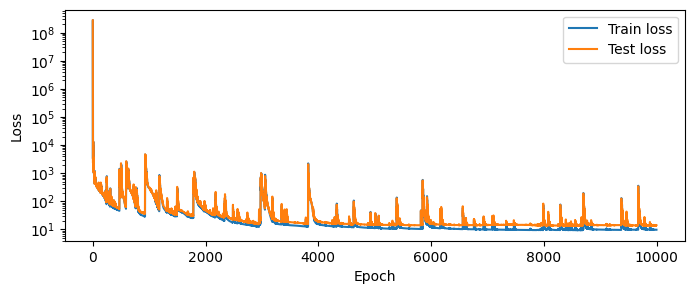

In [6]:
# Train/test loss
fig = plt.figure(figsize=(8, 3))
ax = plot.model_loss(train_loss, test_loss)
plt.show()

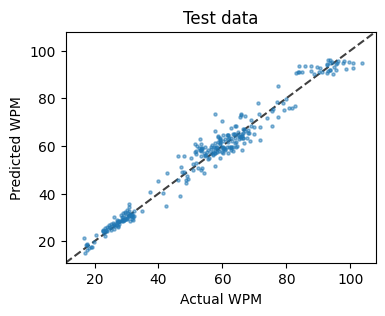

In [7]:
# Test: actual vs predicted wpm
y_pred = model(X_test)
fig = plt.figure(figsize=(4, 3))
ax = plot.model_scatter(y_test.cpu().detach().numpy(), y_pred.cpu().detach().numpy())
ax.set_title("Test data")
plt.show()

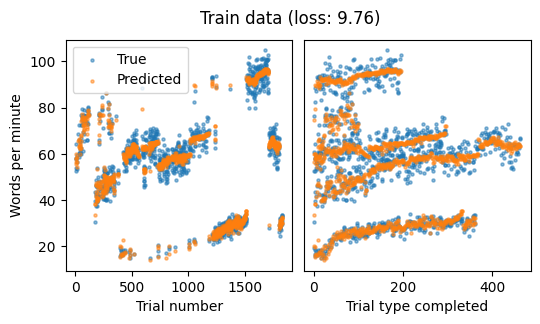

In [8]:
preds = model(X_train)
final_train_loss = loss_function(preds, y_train).item()

fig = plt.figure(figsize=(6, 3))
fig, ax0, ax1 = plot.model_feature_scatter(
    y_train.cpu(), preds.detach().cpu().numpy(), X_train.cpu(), fig=fig
)
fig.suptitle(f"Train data (loss: {final_train_loss:.2f})")
plt.show()

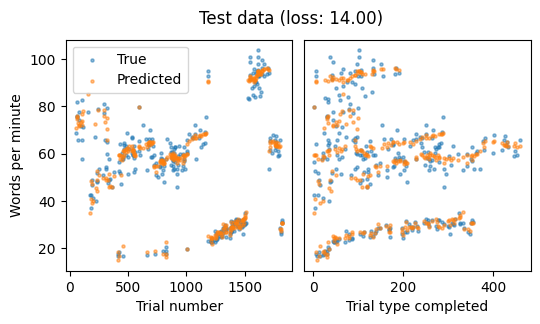

In [9]:
preds = model(X_test)
final_train_loss = loss_function(preds, y_test).item()

fig = plt.figure(figsize=(6, 3))
fig, ax0, ax1 = plot.model_feature_scatter(
    y_test.cpu(), preds.detach().cpu().numpy(), X_test.cpu(), fig=fig
)
fig.suptitle(f"Test data (loss: {final_train_loss:.2f})")
plt.show()

## Predict learning curve from trained model


In [10]:
X_df.head()

,acc,trial_num,trial_type_num,trial_type_id_1,trial_type_id_2,trial_type_id_3,trial_type_id_4,trial_type_id_5
5,91,6,1,0,0,0,0,1
6,95,7,2,0,0,0,0,1
7,93,8,3,0,0,0,0,1
8,93,9,4,0,0,0,0,1
9,90,10,5,0,0,0,0,1


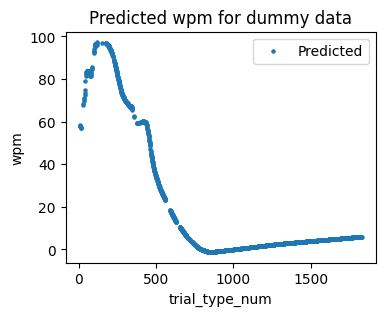

In [11]:
scatter_size = 5
dummy_df = models.generate_dummy_df(X_df, trial_type_id=1)

# Set trial_num to the index+1
dummy_df["trial_num"] = dummy_df.index + 1
# Set trial_type_num to equal trial_num
dummy_df["trial_type_num"] = dummy_df["trial_num"]

# Generate predictions from the model of dummy_df
dummy_X = torch.tensor(dummy_df.values, dtype=torch.float)
if torch.cuda.is_available() and params.use_cuda:
    dummy_X = dummy_X.to(params.device)
dummy_preds = model(dummy_X)

# Plot actual and predicted wpm as function of index
plt.figure(figsize=(4, 3))
plt.scatter(
    dummy_X[:, 2].cpu(),
    dummy_preds.cpu().detach().numpy(),
    label="Predicted",
    s=scatter_size,
)
plt.xlabel("trial_type_num")
plt.ylabel("wpm")
plt.title("Predicted wpm for dummy data")
plt.legend()
plt.show()

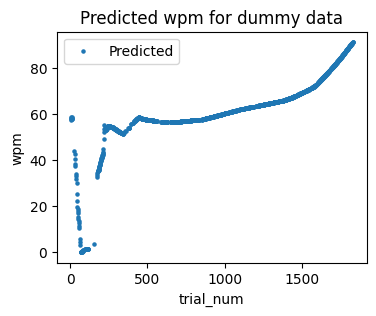

In [12]:
dummy_df = models.generate_dummy_df(X_df, trial_type_id=1)

# Set trial_num to the index+1
dummy_df["trial_num"] = dummy_df.index + 1
# Set trial_type_num to equal trial_num
dummy_df["trial_type_num"] = 1

# Generate predictions from the model of dummy_df
dummy_X = torch.tensor(dummy_df.values, dtype=torch.float)
if torch.cuda.is_available() and params.use_cuda:
    dummy_X = dummy_X.to(params.device)
dummy_preds = model(dummy_X)

# Plot actual and predicted wpm as function of index
plt.figure(figsize=(4, 3))
plt.scatter(
    dummy_X[:, 1].cpu(),
    dummy_preds.cpu().detach().numpy(),
    label="Predicted",
    s=scatter_size,
)
plt.xlabel("trial_num")
plt.ylabel("wpm")
plt.title("Predicted wpm for dummy data")
plt.legend()
plt.show()

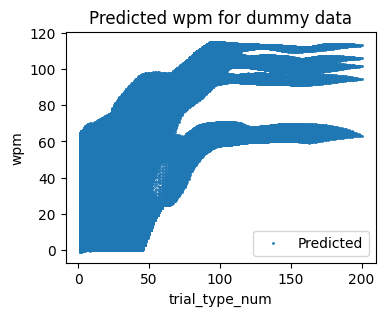

In [13]:
dummy_df = models.generate_dummy_df(X_df, trial_type_id=None)

# Scatter of predicted wpm over trial_type_num
dummy_X = torch.tensor(dummy_df.values, dtype=torch.float)
if torch.cuda.is_available() and params.use_cuda:
    dummy_X = dummy_X.to(params.device)
dummy_preds = model(dummy_X)
plt.figure(figsize=(4, 3))

plt.scatter(
    dummy_X[:, 2].cpu(),
    dummy_preds.cpu().detach().numpy(),
    label="Predicted",
    s=1,
)
plt.xlabel("trial_type_num")
plt.ylabel("wpm")
plt.title("Predicted wpm for dummy data")
plt.legend()
plt.show()

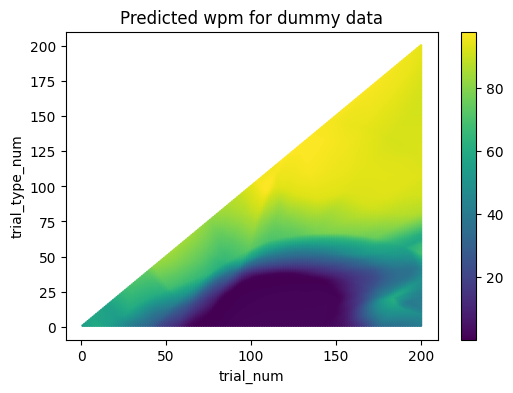

In [14]:
dummy_df = models.generate_dummy_df(X_df, trial_type_id=None)
# Remove all rows where X_df["trial_type_id_1"] == 0
dummy_df = dummy_df[dummy_df["trial_type_id_1"] == 1]

# Scatter of predicted wpm over trial_type_num
dummy_X = torch.tensor(dummy_df.values, dtype=torch.float)
if torch.cuda.is_available() and params.use_cuda:
    dummy_X = dummy_X.to(params.device)
dummy_preds = model(dummy_X)
# Plot 3D of predicted wpm in color as a function of trial_num and trial_type_num
plt.figure(figsize=(6, 4))
x_vals = dummy_X[:, 1].cpu().numpy()
y_vals = dummy_X[:, 2].cpu().numpy()
z_vals = dummy_preds.cpu().detach().numpy()
plt.scatter(x_vals, y_vals, c=z_vals, s=1)
plt.xlabel("trial_num")
plt.ylabel("trial_type_num")
plt.title("Predicted wpm for dummy data")
plt.colorbar()
plt.show()

## Partial Dependence Plot

See <https://christophm.github.io/interpretable-ml-book/pdp.html>

Can use <https://pdpbox.readthedocs.io/en/latest/> or scikit-learn


## Individual Conditional Expectation

See <https://christophm.github.io/interpretable-ml-book/ice.html>
